In [2]:
import string

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm as cm_mlib
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import scipy
from matplotlib import animation, rc, colors
import brian2.units as bunits
import matplotlib as mlib
from scipy import stats
from pprint import pprint as pp
from mpl_toolkits.axes_grid1 import make_axes_locatable, ImageGrid, AxesGrid
import traceback
import os
import copy
from datetime import datetime
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# ensure we use viridis as the default cmap
plt.viridis()

In [3]:
from brian2.units import *

In [4]:
# ensure we use the same rc parameters for all matplotlib outputs
mlib.rcParams.update({'font.size': 24})
mlib.rcParams.update({'errorbar.capsize': 5})
mlib.rcParams.update({'figure.autolayout': True})

In [79]:
# data = np.load("mnist_results__235237_08072019.npz")

# data = np.load("mnist_results_ed_mnist_network_test_100_full_recordings.npz")
data = np.load("..//pynn_object_serialisation/pynn_object_serialisation/"
#                "experiments/mnist_testing/results/mnist_results_ed_mnist_network_test_100_replaced_params_no_neo_tau_0.5.npz")
#                "experiments/mnist_testing/results/mnist_results_ed_mnist_network_test_100_replaced_params_no_neo_tau_0.05.npz")
#                "experiments/mnist_testing/results/mnist_results_ed_mnist_network_test_100_replaced_params_no_neo_tau_0.02.npz")
#                 "experiments/mnist_testing/results/mnist_results_ed_mnist_network_test_100_replaced_params_thresh_1.npz")
#                 "experiments/mnist_testing/results/mnist_results_ed_mnist_network_test_100_replaced_params_thresh_1_tau_1.npz")
#                 "experiments/mnist_testing/results/mnist_results_ed_mnist_network_test_100_diff_scaling.npz")
                "experiments/mnist_testing/results/mnist_results_ed_mnist_network_test_1.npz")
# data = np.load("mnist_results_ed_mnist_network_test.npz")

y_test = data['y_test']
spikes_dict = data['spikes_dict'].ravel()[0]
print(data.files)
print(data['t_stim'])
t_stim=data['t_stim']
runtime=data['runtime']
N_layer=data['N_layer']
output_v=data['output_v']
# neo_spikes_dict=data['neo_spikes_dict']
data.close()

['output_v', 'runtime', 'y_test', 't_stim', 'neo_spikes_dict', 'spikes_dict', 'sim_time', 'N_layer']
2000


In [80]:
spikes_dict

{'00Conv2D_24x24x16': array([], shape=(0, 2), dtype=float64),
 '01DepthwiseConv2D_20x20x64': array([], shape=(0, 2), dtype=float64),
 '03Dense_10': array([], shape=(0, 2), dtype=float64),
 'InputLayer': array([[ 202.,   20.],
        [ 202.,   36.],
        [ 202.,   39.],
        ...,
        [ 741., 1892.],
        [ 741., 1899.],
        [ 741., 1978.]])}

In [39]:
spikes_dict['00Conv2D_24x24x16'].shape

(11992927, 2)

In [40]:
spikes_dict['01DepthwiseConv2D_20x20x64'].shape

(9787984, 2)

In [41]:
spikes_dict['03Dense_10'].shape

(72564, 2)

Min Max


Count: Min 0 Max 572 Mean 46.878826530612244
Hz   : Min 0. Hz Max 286. Hz Mean 23.43941327 Hz


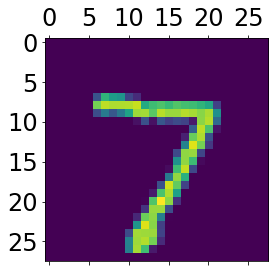

In [93]:
digits_spikes = spikes_dict['InputLayer']
vrpss_neuron_appearances = np.asarray(digits_spikes[:, 0]).astype(int)
nid_bincount = np.bincount(vrpss_neuron_appearances, minlength=28**2)
plt.matshow(nid_bincount.reshape(28, 28))

print("Count: Min", np.min(nid_bincount), "Max", np.max(nid_bincount), "Mean", np.mean(nid_bincount))
nid_bincount = nid_bincount/(runtime * ms)
print("Hz   : Min", np.min(nid_bincount), "Max", np.max(nid_bincount), "Mean", np.mean(nid_bincount))

In [85]:
digits_spikes.shape[0]/(runtime * ms * 1000)

18.3765 * hertz

In [42]:
number_of_examples = runtime // t_stim
actual_test_labels = y_test[:number_of_examples]
correct_order_of_layers = [spikes_dict['00Conv2D_24x24x16'], spikes_dict['01DepthwiseConv2D_20x20x64'], spikes_dict['03Dense_10']]
correct_layer_names = ['00Conv2D_24x24x16', '01DepthwiseConv2D_20x20x64', '03Dense_10']
correct_layer_shapes = [(24,24), (20,20), (10, 1)]

In [43]:
def generate_plots_for_bin(bin_number, layer, layer_shape, layer_name, t_stim=t_stim, number_of_examples=number_of_examples, y_test=y_test, show_plots=False, save_fig=False):
    lower_end_bin_time = bin_number * t_stim
    higher_end_bin_time = (bin_number+1) * t_stim
    
#     layer_name = layer_names[-1]
#     layer_shape = layer_shapes[-1]
    post_spikes = layer
#     print(post_spikes.shape)
    per_neuron_instaneous_rates = np.zeros(layer_shape)

    for nid, val in enumerate(per_neuron_instaneous_rates):
        neuron_index = np.prod(nid)
#         print(nid, neuron_index)
        firings_for_neuron = post_spikes[
            post_spikes[:, 0] == neuron_index]
#         print(firings_for_neuron)
        per_neuron_instaneous_rates[nid] = \
            np.count_nonzero(
                np.logical_and(
                    firings_for_neuron[:, 1] >= (
                            lower_end_bin_time),
                    firings_for_neuron[:, 1] < (
                            higher_end_bin_time)
                )
            ) / (t_stim/1000.)
#         print("{:<4}".format(neuron_index), ":", per_neuron_instaneous_rates)
    instaneous_rates = np.sum(per_neuron_instaneous_rates)
#     print(instaneous_rates)
    
    if instaneous_rates > 0:
        decision_id = np.argmax(per_neuron_instaneous_rates)
    else:
        decision_id = -1
#     print(decision_id)
#     print(y_test[bin_number])
    
    # plot this result
    fig, (ax1) = plt.subplots(1, 1, figsize=(5,5), dpi=300)
    i = ax1.imshow(per_neuron_instaneous_rates)
    ax1.grid(visible=False)
    
    divider = make_axes_locatable(plt.gca())
    cax = divider.append_axes("right", "20%", pad="10%")
    cbar = plt.colorbar(i, cax=cax)
    cbar.set_label("Mean firing rate (Hz)")
    
    if save_fig:
        plt.savefig(
            "layer_{}_bin_{}_truel_{}_predl_{}_info.png".format(layer_name, bin_number, y_test[bin_number], decision_id))
    if show_plots:
        plt.show()
    plt.close(fig)
    
    return per_neuron_instaneous_rates, instaneous_rates, decision_id

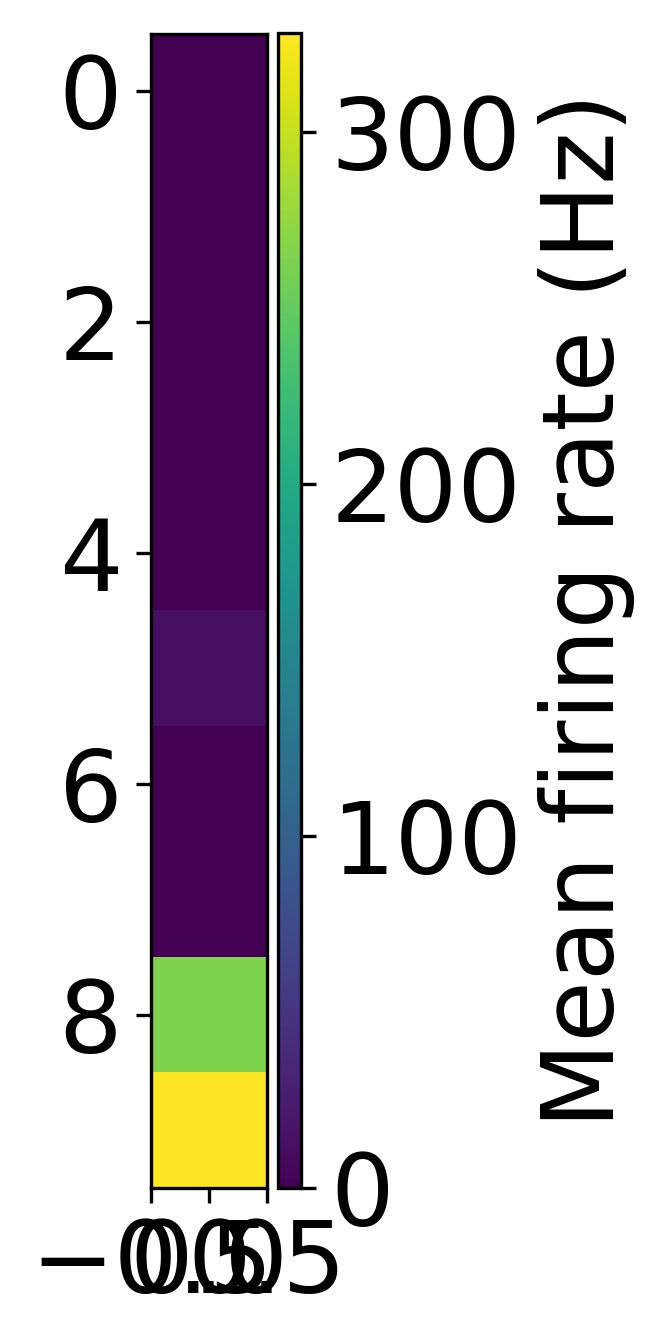

Predicted label 9
Actual    label 9


In [44]:
bin_no = 99
per_neuron_rates, total_rates, pred = generate_plots_for_bin(bin_no, correct_order_of_layers[-1], correct_layer_shapes[-1], correct_layer_names[-1], show_plots=True, save_fig=True)
print("Predicted label", pred)
print("Actual    label", y_test[bin_no])

In [45]:
y_pred = np.ones(number_of_examples) * (-1)
for bin_number in range(number_of_examples):
    per_neuron_rates, total_rates, pred = generate_plots_for_bin(bin_no, correct_order_of_layers[-1], correct_layer_shapes[-1], correct_layer_names[-1], show_plots=False, save_fig=False)
    y_pred[bin_number] = pred

In [46]:
print("Accuracy", np.count_nonzero(y_pred==actual_test_labels)/float(number_of_examples))

Accuracy 0.11


In [47]:
vrpss_neuron_appearances = np.asarray(spikes_dict['InputLayer'][:, 0]).astype(int)
nid_bincount = np.bincount(vrpss_neuron_appearances, minlength=28**2)

In [48]:
inputs_spikes = np.asarray(spikes_dict['InputLayer'])

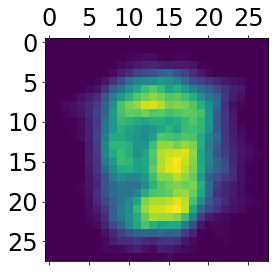

In [49]:
plt.matshow(nid_bincount.reshape(28, 28))

Min neuron occurances 0
Max neuron occurances 306.0


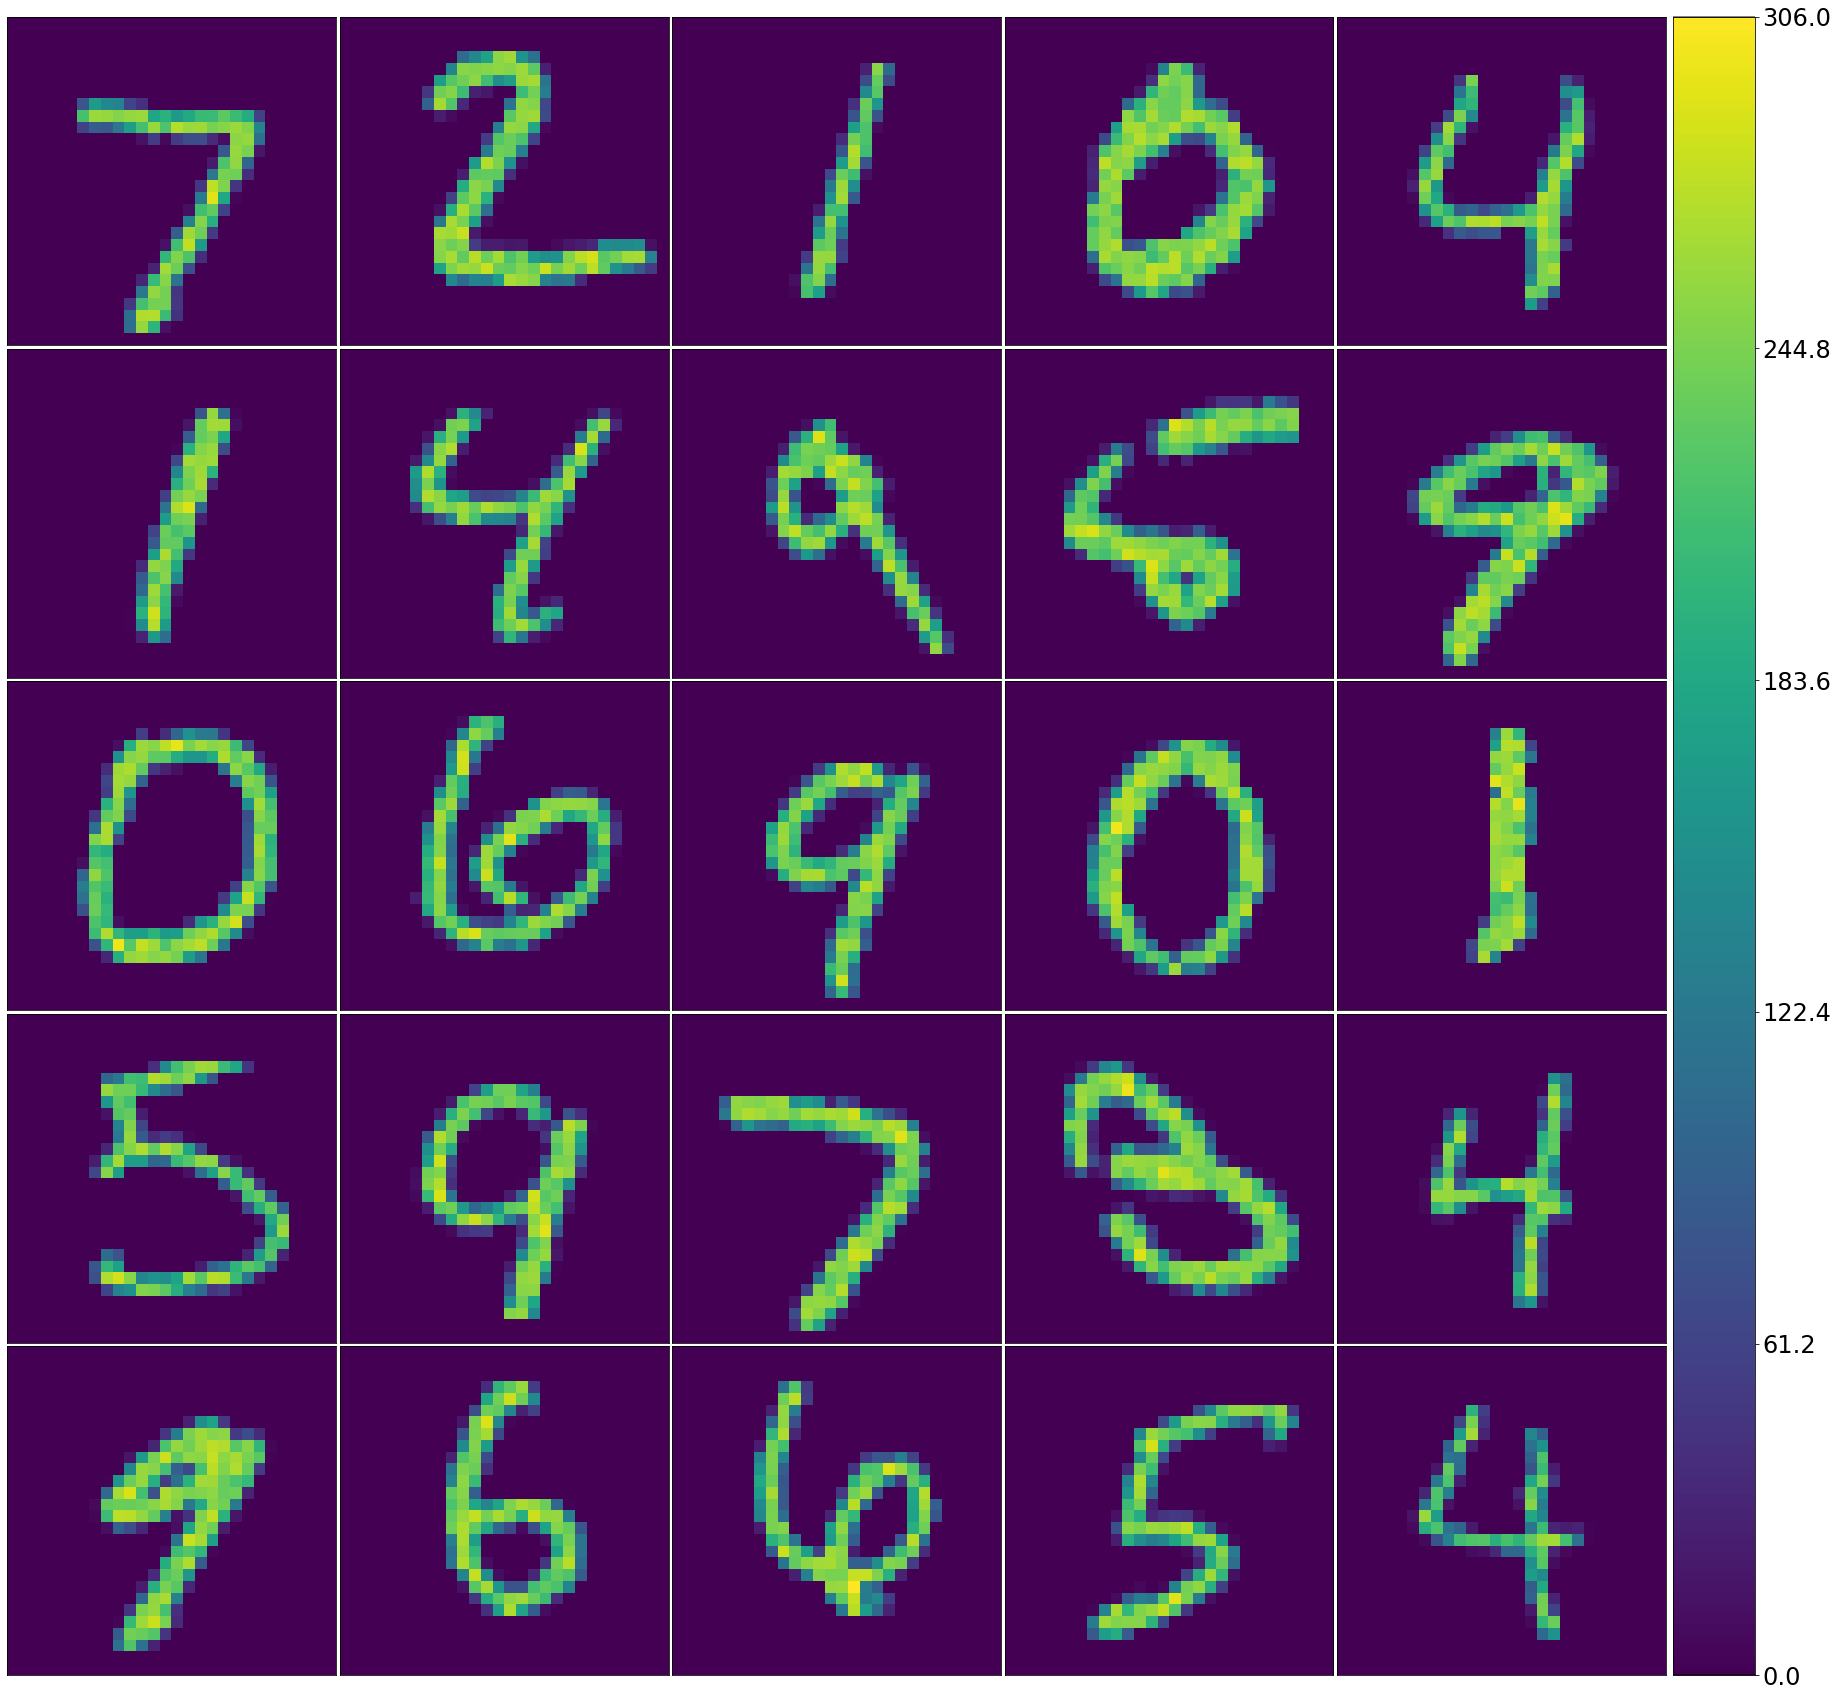

In [50]:
miniplots = 25
# plot this result
side_length = int(np.sqrt(miniplots))

digits_to_plot = np.zeros((miniplots, 28**2))
for adjusted_index in range(miniplots):
    lower_end_bin_time = adjusted_index * t_stim
    higher_end_bin_time = (adjusted_index+1) * t_stim
    spike_filter = np.logical_and(
                    inputs_spikes[:, 1] >= (
                            lower_end_bin_time),
                    inputs_spikes[:, 1] < (
                            higher_end_bin_time)
                )
    digits_to_plot[adjusted_index] = np.bincount(inputs_spikes[spike_filter][:, 0].astype(int), minlength=28**2)
    
minimus = 0
maximus = np.max(digits_to_plot)

print("Min neuron occurances", minimus)
print("Max neuron occurances", maximus)

fig = plt.figure(figsize=(25, 25))

grid = AxesGrid(fig, 111,
                nrows_ncols=(side_length, side_length),
                axes_pad=0.05,
                cbar_mode='single',
                cbar_location='right',
                cbar_pad=0.1
                )
for index, ax in np.ndenumerate(grid):
#     print(index)
#     adjusted_index = index[0] * side_length + index[1]
    adjusted_index = index[0]
    
    i = ax.imshow(digits_to_plot[adjusted_index].reshape(28,28), vmin=minimus, vmax=maximus)
    ax.grid(visible=False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
cbar = ax.cax.colorbar(i)
cbar = grid.cbar_axes[0].colorbar(i)

cbar.ax.set_yticks(np.linspace(minimus, maximus, 6))

plt.savefig("input_digits_{}.png".format(miniplots), pad_inches=.5, bbox_inches='tight')

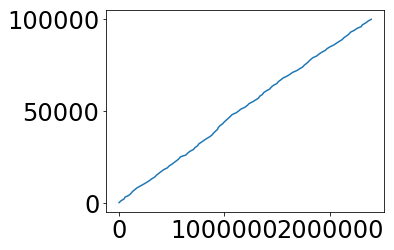

In [30]:
vrpss_spike_times = np.asarray(spikes_dict['InputLayer'][:, 1])
plt.plot(np.sort(vrpss_spike_times))

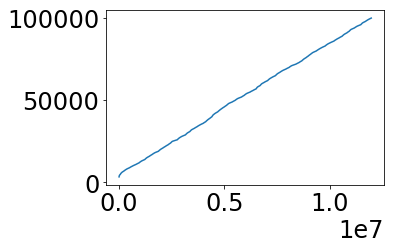

In [32]:
plt.plot(np.sort(correct_order_of_layers[0][:, 1]))

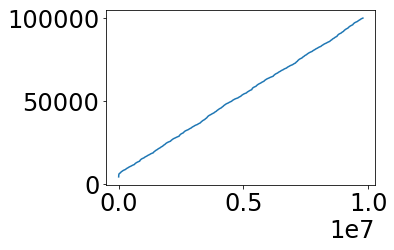

In [33]:
plt.plot(np.sort(correct_order_of_layers[1][:, 1]))

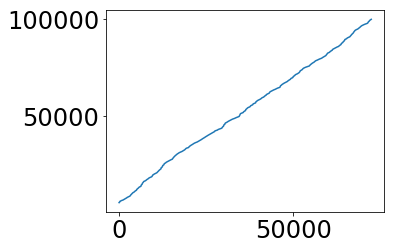

In [34]:
plt.plot(np.sort(correct_order_of_layers[2][:, 1]))

IndexError: too many indices for array

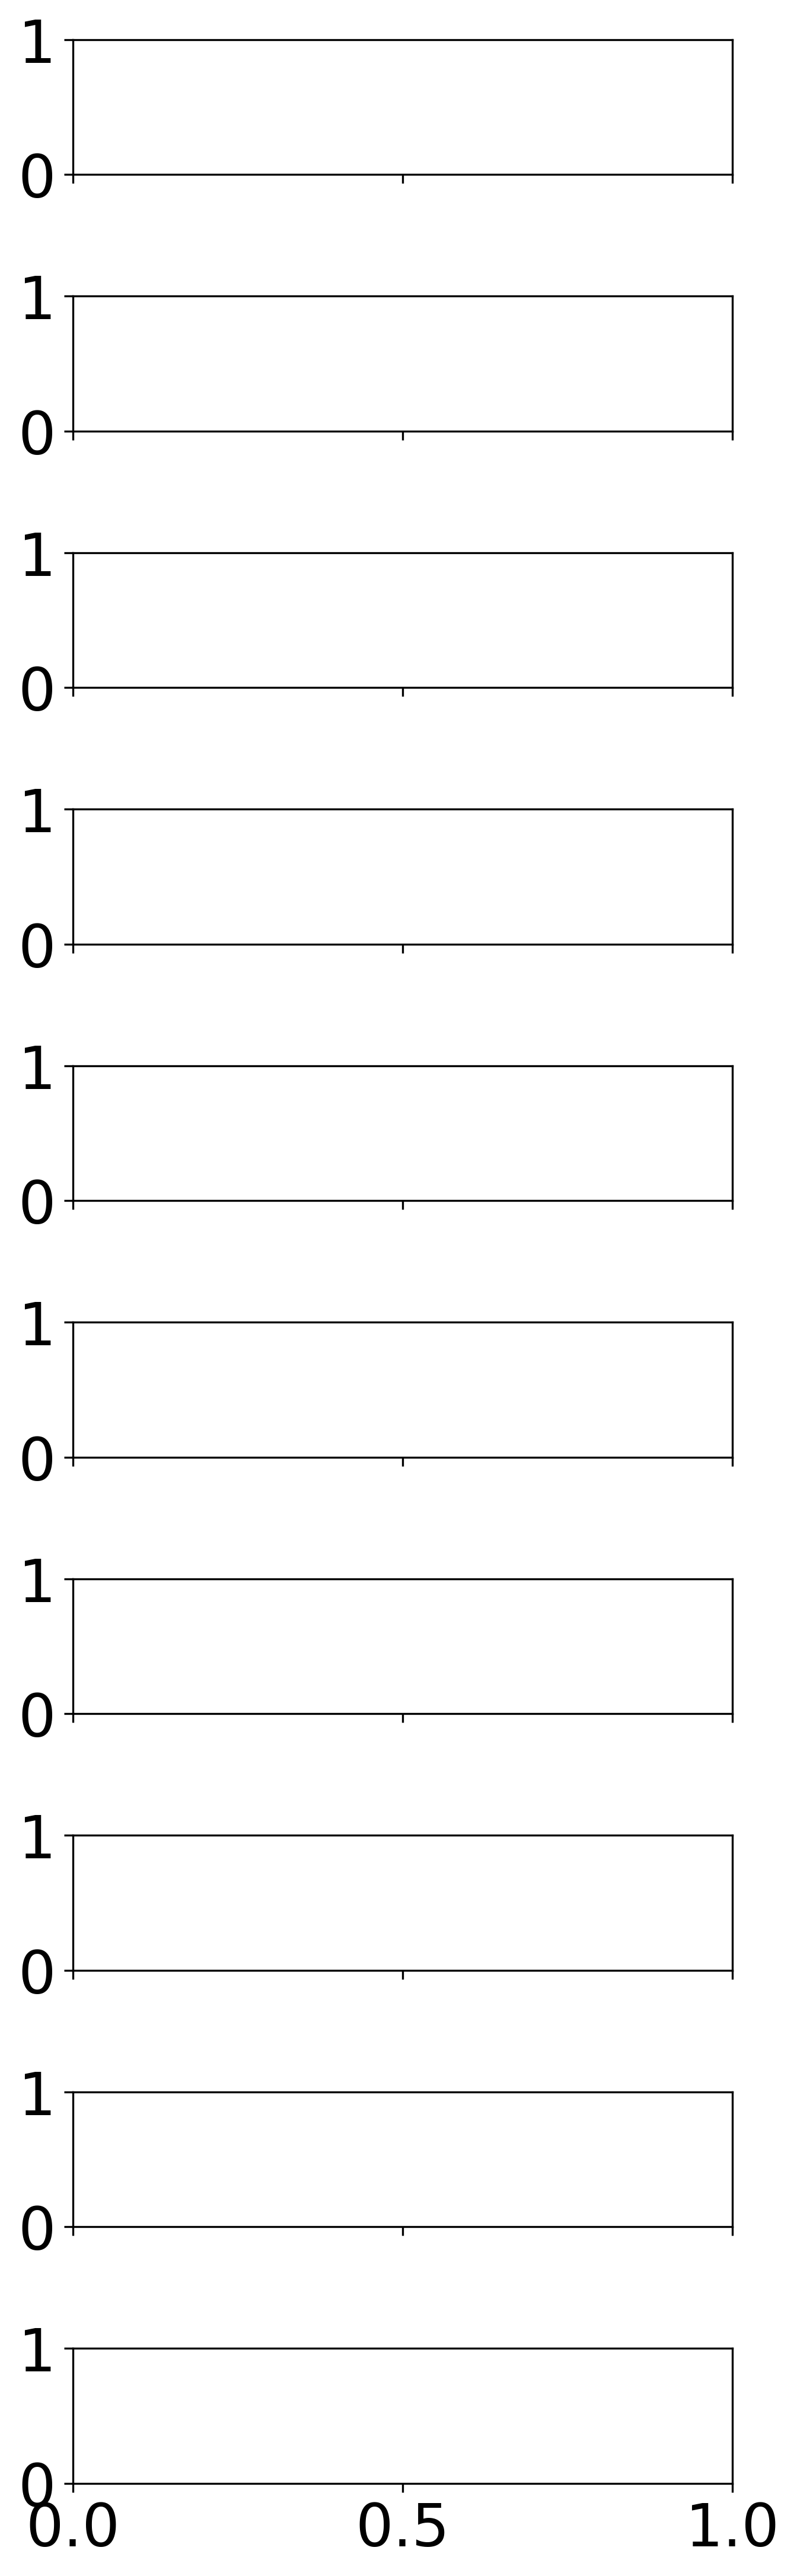

In [51]:
fig, axes = plt.subplots(10, 1, sharex=True, figsize=(5,15), dpi=300)

for nid, ax in enumerate(axes):

    ax.plot(output_v[output_v[:,0]==nid][:, 2])
    ax.set_ylabel("{}".format(nid))
    
plt.savefig("some_v_info_output_neurons.png")

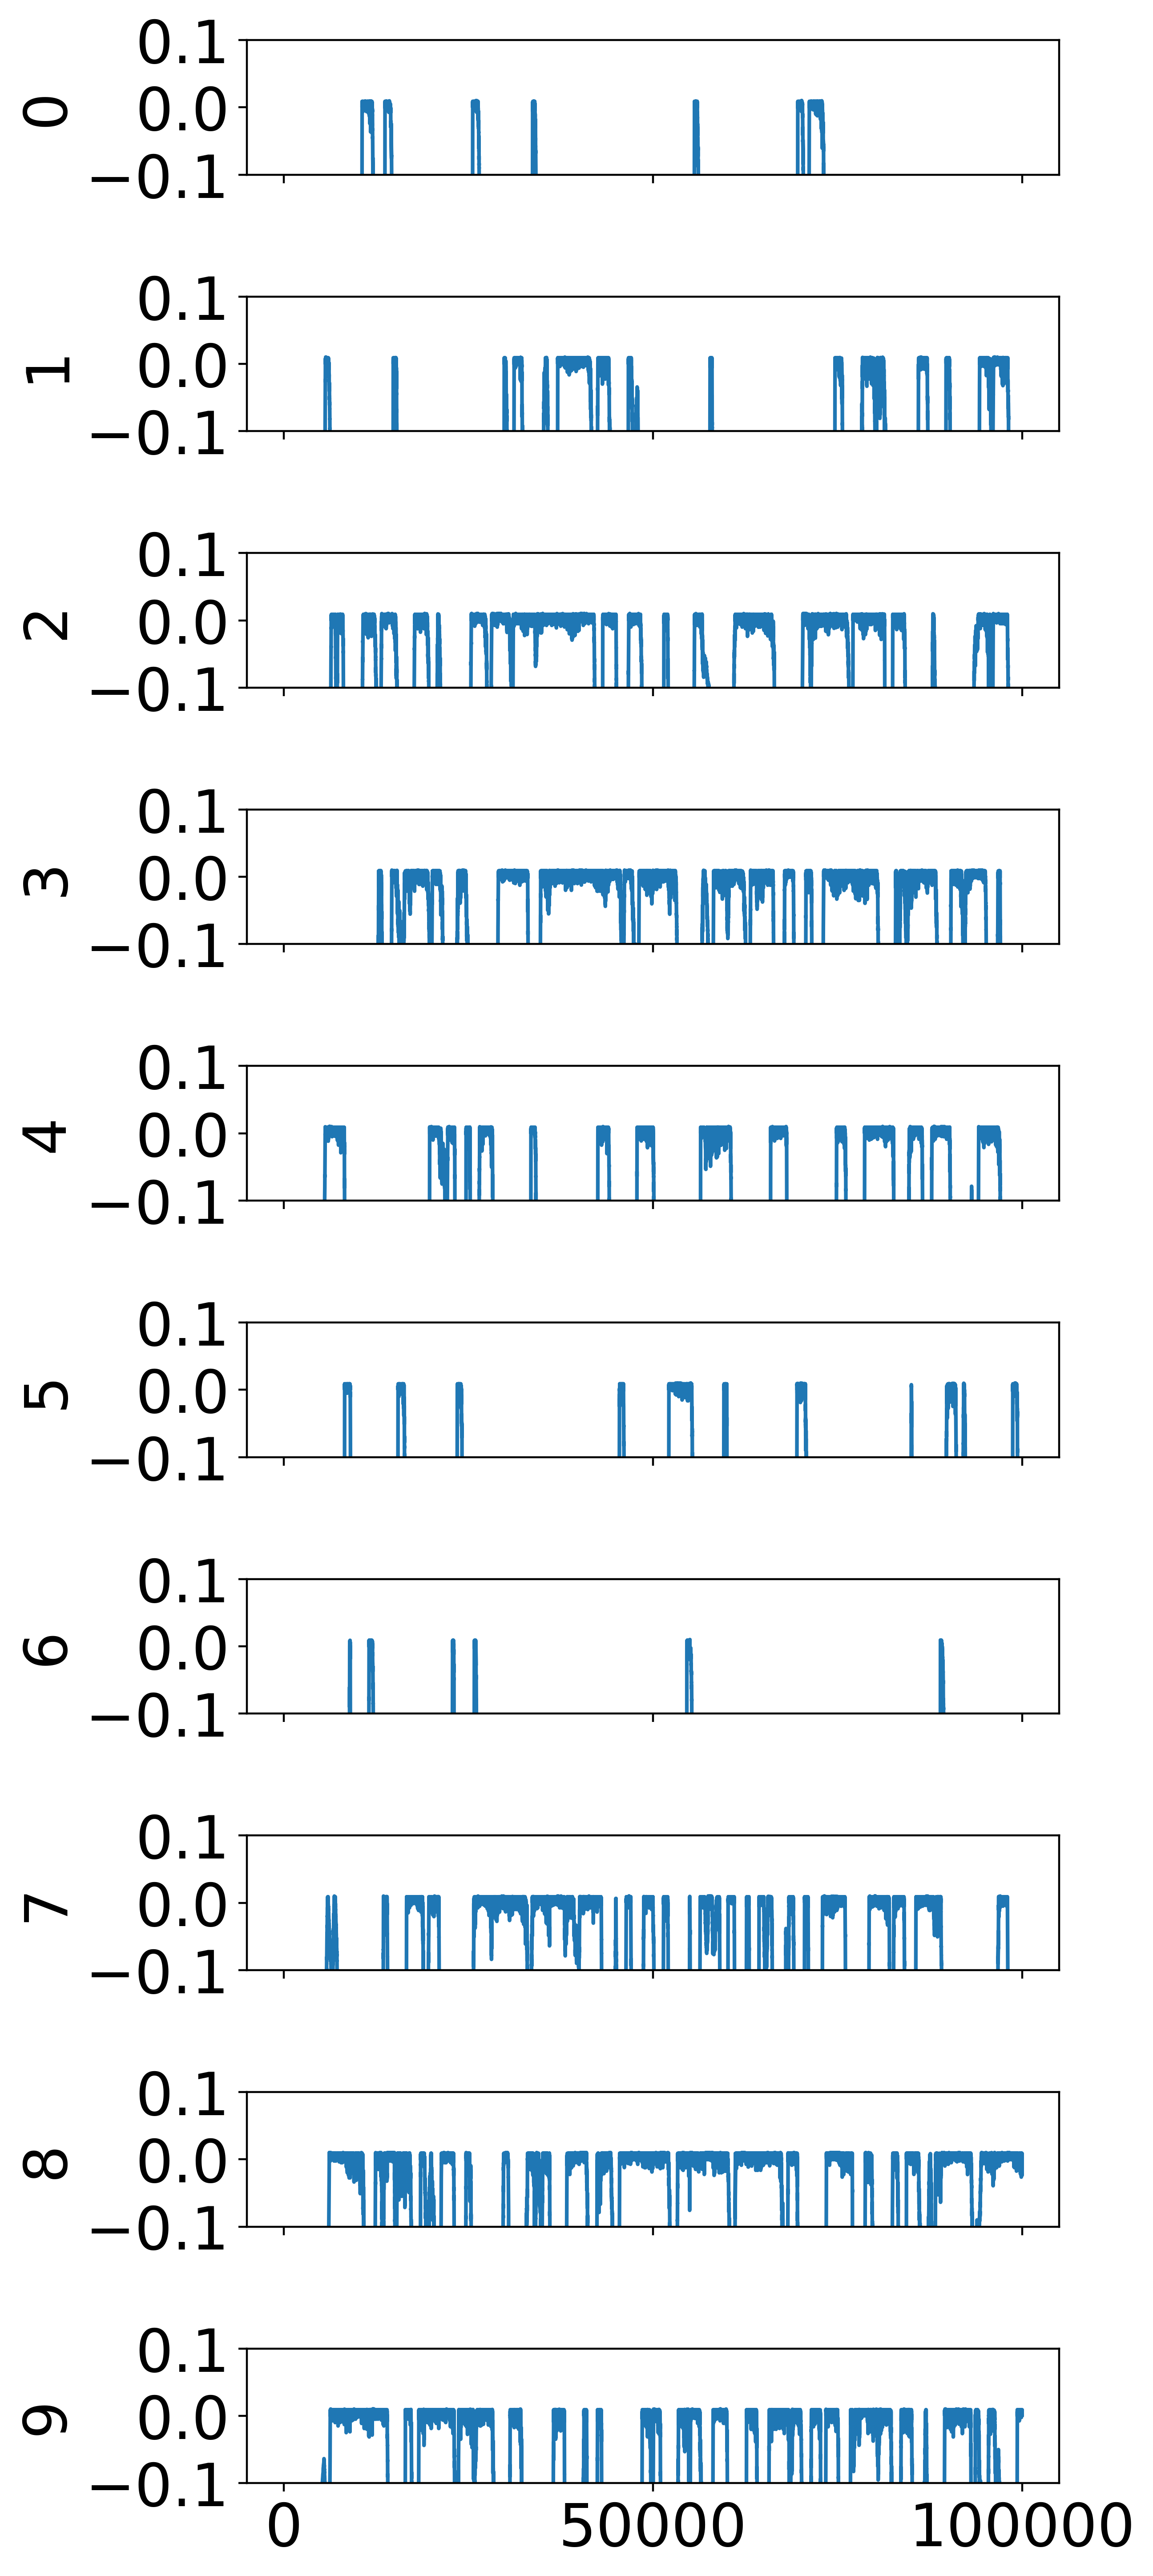

In [120]:
fig, axes = plt.subplots(10, 1, sharex=True, figsize=(7,15), dpi=400)
for nid, ax in enumerate(axes):
    ax.plot(output_v[output_v[:,0]==nid][:, 2])
    ax.set_ylabel("{}".format(nid))
    ax.set_ylim([-0.1, 0.1])
    
plt.savefig("clipped_some_v_info_output_neurons.png")

In [52]:
ed_spikes = np.load("ed_spikes.npz")

In [53]:
ed_spikes.files

['spiketrains_n_b_l_t',
 'top1err_b_t',
 'top5err_b_t',
 'top1err_ann',
 'top5err_ann',
 'operations_ann',
 'input_image_b_l',
 'true_classes_b',
 'avg_rate']

In [76]:
spikes = ed_spikes['spiketrains_n_b_l_t']
avg_rate = ed_spikes['avg_rate']
layer_name = spikes[0][1]
print("Layer name", layer_name)

Layer name 00Conv2D_24x24x16


In [61]:
spikes.shape

(3, 2)

In [60]:
avg_rate

array(0.02380736)

In [66]:
spikes[0][0].shape

(1, 24, 24, 16, 300)

In [78]:
np.argwhere(spikes[0][0]!=0)

array([[  0,   3,   2,   0,  75],
       [  0,   3,   2,   0, 144],
       [  0,   3,   2,   0, 207],
       ...,
       [  0,  23,  14,  15, 241],
       [  0,  23,  14,  15, 269],
       [  0,  23,  14,  15, 297]])

In [89]:
maybe_number_of_spikes = spikes[0][0][np.where(spikes[0][0]!=0)].shape

In [74]:
img = ed_spikes['input_image_b_l']
print("Min", np.min(img),  "Max", np.max(img), "Mean", np.mean(img), )

Min 0.0 Max 1.0 Mean 0.092306934


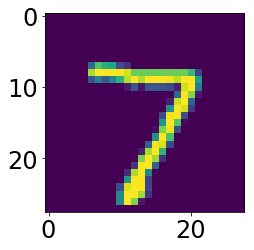

In [73]:
plt.imshow(img.reshape(28, 28))

In [90]:
maybe_number_of_spikes / (300 * ms)

array([0.37737333]) * Mhertz

In [91]:
maybe_number_of_neurons = 24 * 24 * 16

In [92]:
maybe_number_of_spikes / (maybe_number_of_neurons * 300 * ms)

array([40.94762731]) * hertz

In [111]:
some_sum = np.sum(np.sum(spikes[0][0], axis=-1), axis=-1)/(300 * ms)

In [112]:
spikes[0][0].shape

(1, 24, 24, 16, 300)

In [113]:
some_sum.shape

(1, 24, 24)

Min 0. Hz Max 50.83478009 Hz Mean 10.78659309 Hz


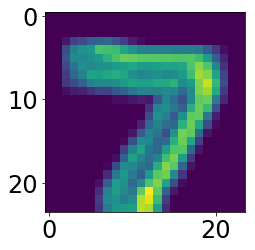

In [116]:
the_sum = some_sum[0, :, :]
maybe_number_of_neurons = 24**2*16
plt.imshow(the_sum/Hz)
print("Min", np.min(the_sum)/maybe_number_of_neurons,  "Max", np.max(the_sum)/maybe_number_of_neurons, "Mean", np.mean(the_sum)/maybe_number_of_neurons, )

# Let's try generating Poisson spike trains using elephant

In [122]:
import elephant
from quantities import ms, Hz
from keras.datasets import mnist

Using TensorFlow backend.


In [159]:
# data = np.load("mnist_results__235237_08072019.npz")

# data = np.load("mnist_results_ed_mnist_network_test_100_full_recordings.npz")
data = np.load("..//pynn_object_serialisation/pynn_object_serialisation/"
                "experiments/mnist_testing/results/mnist_results_ed_mnist_network_test_1.npz")
# data = np.load("mnist_results_ed_mnist_network_test.npz")

y_test = data['y_test']
spikes_dict = data['spikes_dict'].ravel()[0]
print(data.files)
print(data['t_stim'])
t_stim=data['t_stim']
runtime=data['runtime']
N_layer=data['N_layer']
data.close()

['runtime', 'y_test', 'neo_spikes_dict', 'N_layer', 'output_v', 't_stim', 'sim_time', 'spikes_dict']
1000


In [160]:
N_layer = 28 ** 2  # number of neurons in each population
t_stim = 1000
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# reshape input to flatten data
x_train = x_train.reshape(x_train.shape[0], np.prod(x_train.shape[1:]))
x_test = x_test.reshape(x_test.shape[0], np.prod(x_test.shape[1:]))


testing_examples = 1


runtime = testing_examples * t_stim
number_of_slots = int(runtime / t_stim)
range_of_slots = np.arange(number_of_slots)
starts = np.ones((N_layer, number_of_slots)) * (range_of_slots * t_stim)
durations = np.ones((N_layer, number_of_slots)) * t_stim
# rates = np.random.randint(1, 5, size=(N_layer, number_of_slots))
rates = x_test[:testing_examples, :].T
input_params = {
    "rates": rates,
    "durations": durations,
    "starts": starts
}
# scaling rates
_0_to_1_rates = rates / float(np.max(rates))
rates = _0_to_1_rates * 1000

Count: Min 0 Max 999 Mean 90.90816326530613
Hz   : Min 0.0 Max 999.0 Mean 90.90816326530613


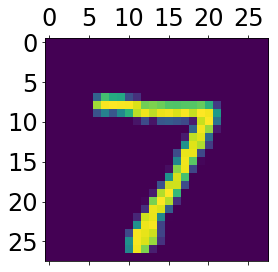

In [161]:
digits_spikes = spikes_dict['InputLayer']
vrpss_neuron_appearances = np.asarray(digits_spikes[:, 0]).astype(int)
nid_bincount = np.bincount(vrpss_neuron_appearances, minlength=28**2)
plt.matshow(nid_bincount.reshape(28, 28))

print("Count: Min", np.min(nid_bincount), "Max", np.max(nid_bincount), "Mean", np.mean(nid_bincount))
nid_bincount = nid_bincount/(runtime /1000)
print("Hz   : Min", np.min(nid_bincount), "Max", np.max(nid_bincount), "Mean", np.mean(nid_bincount))

In [162]:
poisson_spikes = [] 
number_of_entries = []

for i, v in enumerate(rates.ravel()):
    poisson_spikes.append(elephant.spike_train_generation.homogeneous_poisson_process(
    v * Hz, 
    t_start=0. * ms, 
    t_stop=1000. * ms,
    as_array=True))
    number_of_entries.append(len(poisson_spikes[i]))
number_of_entries = np.asarray(number_of_entries)

In [163]:
print("Rates: Min", np.min(rates),  "Max", np.max(rates), 
      "Mean", np.mean(rates), )
print("Eleph: Min", np.min(number_of_entries),  "Max", np.max(number_of_entries), 
      "Mean", np.mean(number_of_entries), )
print("VRPSS: Min", np.min(nid_bincount), "Max", np.max(nid_bincount), "Mean", np.mean(nid_bincount))

Rates: Min 0.0 Max 1000.0 Mean 92.30692276910764
Eleph: Min 0 Max 1091 Mean 92.13647959183673
VRPSS: Min 0.0 Max 999.0 Mean 90.90816326530613


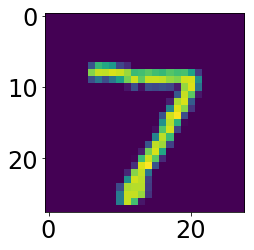

In [164]:
plt.imshow(number_of_entries.reshape(28, 28))